In [2]:
import csv
#from optparse import OptionParser
from matplotlib import pyplot as plt
import numpy as np
from random import random
import pandas as pd
from numpy.linalg import pinv
from numpy.linalg import inv


In [3]:
data=pd.read_csv("C:/Users/subha/OneDrive/Desktop/Project/data/f10.7cm_radio_flux_data.csv")
data=pd.DataFrame(data)

In [4]:
data.head()

,yy,mm,dd,F10.7
0,1957,10,1,269.8
1,1957,10,2,253.6
2,1957,10,3,266.4
3,1957,10,4,238.2
4,1957,10,5,246.0


In [5]:
cols=["yy","mm","dd"]
data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [6]:
data.head()

,yy,mm,dd,F10.7,date
0,1957,10,1,269.8,1957-10-1
1,1957,10,2,253.6,1957-10-2
2,1957,10,3,266.4,1957-10-3
3,1957,10,4,238.2,1957-10-4
4,1957,10,5,246.0,1957-10-5


In [7]:
data['date']=pd.to_datetime(data['date'])

In [8]:
data=data.drop(['yy','mm','dd'], axis=1)

In [9]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [10]:
data.head()

,F10.7
date,
1957-10-01,269.8
1957-10-02,253.6
1957-10-03,266.4
1957-10-04,238.2
1957-10-05,246.0


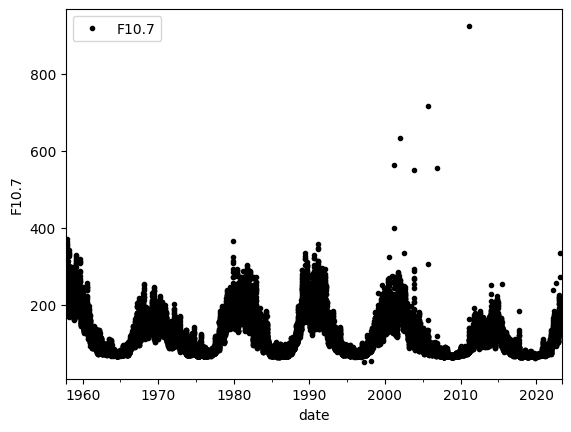

In [11]:
%matplotlib inline
data = data.astype(float)
data
data.plot(style='k.',ylabel='F10.7')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
import math


data = np.array(data)
data = np.reshape(data, (-1, 1))
data


array([[269.8],
       [253.6],
       [266.4],
       ...,
       [154.1],
       [168.5],
       [173.7]])

In [13]:
m = 14
per = (23946 - m)/23973
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]
mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

In [14]:
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])
for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])
for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23918, 14)
(23918, 1)
(27, 14)
(27, 1)


In [15]:
import scipy.stats as stats

input_size = X_train.shape[1]
hidden_size = 100   #no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1 
w_hi = 1
b_lo = -1 
b_hi = 1

In [16]:
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)


In [17]:
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H
output_weights = np.dot(pinv(hidden_nodes(X_train)), y_train)
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out
prediction = predict(X_test)

In [18]:
correct = 0
total = X_test.shape[0]
y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)


Test RMSE: 10.165
Test MAPE: 4.514
Test MPE: 0.073


In [20]:
prediction

array([[132.92510806],
       [132.15562096],
       [132.39673401],
       [142.96619946],
       [146.30446196],
       [157.24568674],
       [161.78440476],
       [163.47685933],
       [152.17887526],
       [157.78421089],
       [157.46376086],
       [160.63856851],
       [165.32785702],
       [159.6159224 ],
       [159.21301712],
       [171.81028604],
       [197.40070181],
       [181.67771423],
       [168.45653692],
       [149.08719645],
       [137.9740887 ],
       [142.25895006],
       [134.58354693],
       [142.41681799],
       [142.95030601],
       [160.88161545],
       [174.26603134]])

Text(0.5, 1.0, 'Forecasting for last 27 days with ELM (100 hidden nodes)')

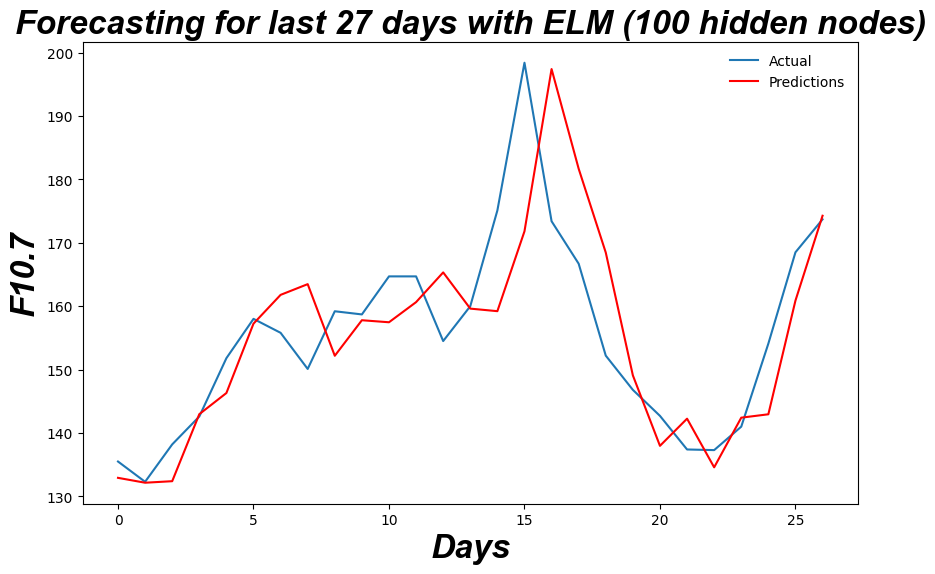

In [19]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('F10.7',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Forecasting for last 27 days with ELM (100 hidden nodes)',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
